In [1]:
# ============================================================
# Library Imports
# ============================================================
import sys
import platform
import os
import psutil
import pandas as pd
import numpy as np
import kagglehub
from kagglehub import KaggleDatasetAdapter
import matplotlib
import matplotlib.pyplot as plt
from scipy import stats

# ============================================================
# Version & Environment Info
# ============================================================
print("="*70)
print("Environment & Library Versions")
print("="*70)
print(f"Python version      : {sys.version.split()[0]}")
print(f"Platform            : {platform.platform()}")
print(f"Processor           : {platform.processor() or 'Unknown'}")
print(f"Machine             : {platform.machine()}")
print(f"CPU Count (logical) : {psutil.cpu_count(logical=True)}")
print(f"RAM Total (GB)      : {round(psutil.virtual_memory().total / (1024**3), 2)} GB")
print("-"*70)
print(f"pandas              : {pd.__version__}")
print(f"numpy               : {np.__version__}")
print(f"matplotlib          : {matplotlib.__version__}")
print(f"scipy               : {stats.__version__ if hasattr(stats, '__version__') else 'N/A'}")
print(f"kagglehub           : {kagglehub.__version__}")
print("-"*70)
print(f"Working Directory   : {os.getcwd()}")
print("="*70)

Environment & Library Versions
Python version      : 3.13.4
Platform            : Windows-11-10.0.26100-SP0
Processor           : Intel64 Family 6 Model 126 Stepping 5, GenuineIntel
Machine             : AMD64
CPU Count (logical) : 8
RAM Total (GB)      : 15.77 GB
----------------------------------------------------------------------
pandas              : 2.3.1
numpy               : 2.3.1
matplotlib          : 3.10.7
scipy               : N/A
kagglehub           : 0.3.13
----------------------------------------------------------------------
Working Directory   : D:\learn\portf\walmart_sales


In [2]:
# load data
# source : https://www.kaggle.com/datasets/mikhail1681/walmart-sales
file_path = "Walmart_Sales.csv"
df = kagglehub.dataset_load(
  KaggleDatasetAdapter.PANDAS,
  "mikhail1681/walmart-sales",
  file_path,
)

In [3]:
# raw data check
print(df.head())
print(df.info())

   Store        Date  Weekly_Sales  Holiday_Flag  Temperature  Fuel_Price  \
0      1  05-02-2010    1643690.90             0        42.31       2.572   
1      1  12-02-2010    1641957.44             1        38.51       2.548   
2      1  19-02-2010    1611968.17             0        39.93       2.514   
3      1  26-02-2010    1409727.59             0        46.63       2.561   
4      1  05-03-2010    1554806.68             0        46.50       2.625   

          CPI  Unemployment  
0  211.096358         8.106  
1  211.242170         8.106  
2  211.289143         8.106  
3  211.319643         8.106  
4  211.350143         8.106  
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6435 entries, 0 to 6434
Data columns (total 8 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Store         6435 non-null   int64  
 1   Date          6435 non-null   object 
 2   Weekly_Sales  6435 non-null   float64
 3   Holiday_Flag  6435 non-null   i

In [4]:
# transform 1
df['Date'] = pd.to_datetime(df['Date'], format='%d-%m-%Y', errors='coerce')
df = df.dropna(subset=['Date']).copy()
df = df.sort_values(['Store', 'Date']).reset_index(drop=True)
df['Year'] = df['Date'].dt.year
df['Month'] = df['Date'].dt.month
df['Week'] = df['Date'].dt.isocalendar().week.astype('UInt32')
df['DayOfWeek'] = df['Date'].dt.dayofweek.astype('int8')
df['Store'] = df['Store'].astype('category')
df['Holiday_Flag'] = df['Holiday_Flag'].astype('category')
df['Holiday'] = df['Holiday_Flag'].cat.rename_categories({0:'No Holiday', 1:'Holiday'})
df['Sales_3week_MA'] = (
    df.groupby('Store', observed=True)['Weekly_Sales']
      .transform(lambda x: x.rolling(window=3, min_periods=1).mean())
)
df['Sales_12week_MA'] = (
    df.groupby('Store', observed=True)['Weekly_Sales']
      .transform(lambda x: x.rolling(window=12, min_periods=1).mean())
)
df['Temp_Bin'] = pd.cut(df['Temperature'],
                        bins=[-1e9, 40, 60, 80, 1e9],
                        labels=['Cold', 'Mild', 'Warm', 'Hot'],
                        include_lowest=True)
df['Temp_Bin'] = pd.Categorical(df['Temp_Bin'], 
                                categories=['Cold', 'Mild', 'Warm', 'Hot'], 
                                ordered=True)
def get_season(month):
    if month in [12, 1, 2]:
        return 'Winter'
    elif month in [3, 4, 5]:
        return 'Spring'
    elif month in [6, 7, 8]:
        return 'Summer'
    else:
        return 'Fall'
df['Season'] = df['Month'].apply(get_season)

In [5]:
# transform 2
monthly_sales = (
    df.groupby(['Store', 'Year', 'Month'], observed=True)['Weekly_Sales']
      .sum()
      .reset_index()
)
holiday_sales = (
    df.groupby('Holiday', observed=True)['Weekly_Sales']
      .mean()
      .reset_index()
)

Found 135 outlier rows (>3 std deviations from mean)


<Figure size 1200x500 with 0 Axes>

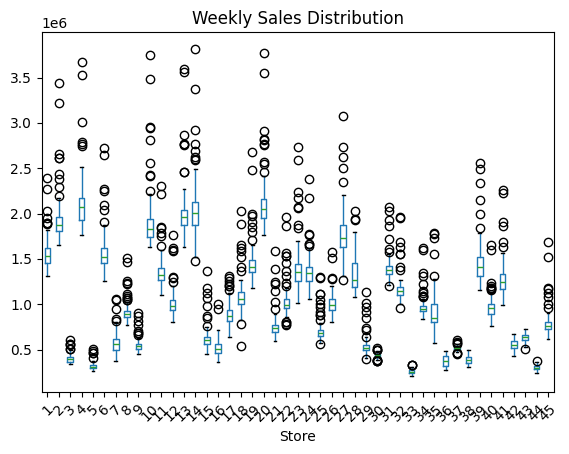

In [6]:
# Outlier detection using z-score
df['zscore_sales'] = (
    df.groupby('Store', observed=True)['Weekly_Sales']
      .transform(lambda x: stats.zscore(x, nan_policy='omit'))
)
outlier_rows = df[np.abs(df['zscore_sales']) > 3]
print(f"Found {len(outlier_rows)} outlier rows (>3 std deviations from mean)")

df['is_outlier'] = np.where(np.abs(df['zscore_sales']) > 3, 1, 0)

plt.figure(figsize=(12,5))
sample_stores = df['Store'].unique()
df[df['Store'].isin(sample_stores)].boxplot(column='Weekly_Sales', by='Store', grid=False, rot=45)
plt.title('Weekly Sales Distribution')
plt.suptitle('')
plt.show()

In [7]:
# Summary statistics per store
store_summary = (
    df.groupby('Store', observed=True)
      .agg(
          mean_sales=('Weekly_Sales', 'mean'),
          median_sales=('Weekly_Sales', 'median'),
          outlier_pct=('is_outlier', lambda x: 100 * x.mean())
      )
      .sort_values('mean_sales', ascending=False)
      .round(2)
)
display(store_summary.head(10))
avg_outlier_pct = store_summary['outlier_pct'].mean()
print(f"Average percentage of outliers between stores: {avg_outlier_pct:.2f}%")

,mean_sales,median_sales,outlier_pct
Store,,,
20,2107676.87,2053165.41,1.4
4,2094712.96,2073951.38,2.1
14,2020978.40,2004330.30,1.4
13,2003620.31,1958823.56,2.1
2,1925751.34,1879107.31,2.1
10,1899424.57,1827521.71,3.5
27,1775216.20,1731935.43,2.8
6,1564728.19,1524390.07,2.8
1,1555264.40,1534849.64,2.1


Average percentage of outliers between stores: 2.10%


In [8]:
# Dataset health overview
def data_health_report(df):
    report = {
        'Total Rows': len(df),
        'Missing Values (any)': df.isna().any(axis=1).sum(),
        'Temp Null %': round(df['Temperature'].isna().mean()*100, 2),
        'Sales Null %': round(df['Weekly_Sales'].isna().mean()*100, 2),
        'Outlier %': round(df['is_outlier'].mean()*100, 2)
    }
    return pd.Series(report)
print("Data Quality Summary:")
display(data_health_report(df))

Data Quality Summary:


Total Rows              6435.0
Missing Values (any)       0.0
Temp Null %                0.0
Sales Null %               0.0
Outlier %                  2.1
dtype: float64

In [9]:
# Validate Outlier Detection
df_outliers = df.loc[df['is_outlier'] == 1]

In [10]:
holiday_dist = df['Holiday'].value_counts(normalize=True) * 100
outlier_dist = df_outliers['Holiday'].value_counts(normalize=True) * 100
comparison = pd.DataFrame({
    'All Data (%)': holiday_dist,
    'Outliers (%)': outlier_dist
}).fillna(0).round(2)
print("\nComparison of Holiday proportions:")
print(comparison)


Comparison of Holiday proportions:
            All Data (%)  Outliers (%)
Holiday                               
No Holiday         93.01         62.22
Holiday             6.99         37.78


<Axes: title={'center': 'Holiday vs No-Holiday Outlier Proportion (%)'}, xlabel='Holiday'>

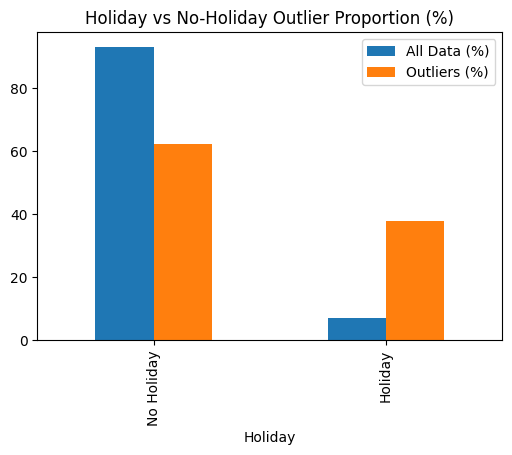

In [11]:
comparison.plot(kind='bar', figsize=(6,4), title='Holiday vs No-Holiday Outlier Proportion (%)')

In the dataset, only about 7% of weeks are labeled as holidays, yet these weeks contribute to nearly 38% of all statistical outliers. This indicates that holiday weeks are much more likely to exhibit extreme sales behavior — typically sharp spikes or drops compared to normal weeks.
In contrast, non-holiday weeks make up 93% of all data but only 62% of the outliers, showing that while normal weeks dominate in volume, their variability is relatively stable.
Although holiday weeks represent a small fraction of total periods (7%), they disproportionately contribute to sales outliers (≈38%). This suggests that holidays drive unusually high or volatile sales patterns, reinforcing their strong influence on retail performance and supporting the decision to retain these outlier records for analysis.

In [12]:
season_dist = df['Season'].value_counts(normalize=True) * 100
outlier_season_dist = df_outliers['Season'].value_counts(normalize=True) * 100
season_comparison = pd.DataFrame({
    'All Data (%)': season_dist,
    'Outliers (%)': outlier_season_dist
}).fillna(0).round(2)

print("\nComparison of Season proportions:")
print(season_comparison)


Comparison of Season proportions:
        All Data (%)  Outliers (%)
Season                            
Fall           23.78         37.78
Spring         27.27          0.00
Summer         27.97          0.00
Winter         20.98         62.22


Although Winter and Fall together represent less than half of all weeks (≈44%), every identified outlier occurs during these two seasons. Winter alone accounts for 62% of all outliers. This indicates that extreme sales behavior is strongly seasonal, concentrated in colder months when major holidays and promotional events drive significant deviations in weekly sales.

In [13]:
# clean data check
print(df.tail())
print(df.info())

     Store       Date  Weekly_Sales Holiday_Flag  Temperature  Fuel_Price  \
6430    45 2012-09-28     713173.95            0        64.88       3.997   
6431    45 2012-10-05     733455.07            0        64.89       3.985   
6432    45 2012-10-12     734464.36            0        54.47       4.000   
6433    45 2012-10-19     718125.53            0        56.47       3.969   
6434    45 2012-10-26     760281.43            0        58.85       3.882   

             CPI  Unemployment  Year  Month  Week  DayOfWeek     Holiday  \
6430  192.013558         8.684  2012      9    39          4  No Holiday   
6431  192.170412         8.667  2012     10    40          4  No Holiday   
6432  192.327265         8.667  2012     10    41          4  No Holiday   
6433  192.330854         8.667  2012     10    42          4  No Holiday   
6434  192.308899         8.667  2012     10    43          4  No Holiday   

      Sales_3week_MA  Sales_12week_MA Temp_Bin Season  zscore_sales  \
6430   71

In [14]:
# save the clean data to csv
df.to_csv(r'.\data\walmart_sales_data.csv', encoding='utf-8', index=False)